Files already downloaded and verified
Files already downloaded and verified


C:\Users\CGarc\AppData\Local\Temp\ipykernel_25120\2932068433.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location='cpu')


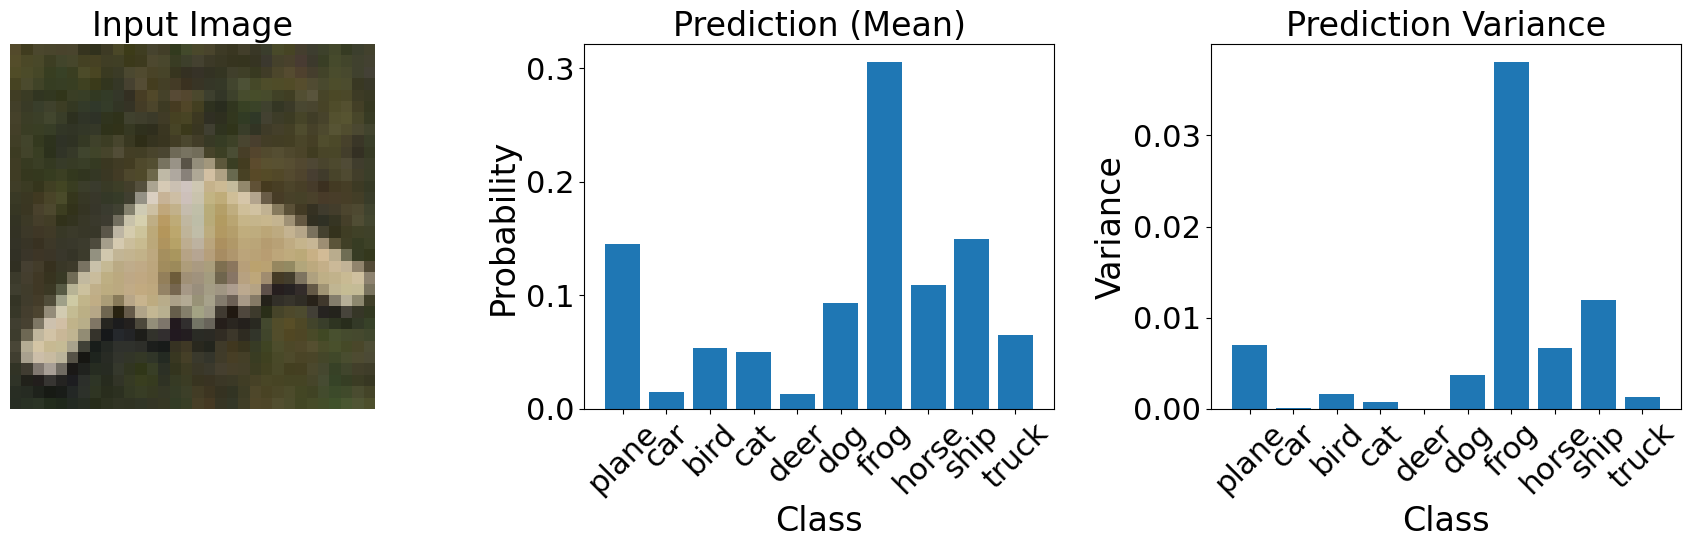

In [2]:
from bayesViT import bayesViT
from data import get_dataloaders
import torchvision.transforms as transforms
import os
import torch.nn as nn
import numpy as np
import torch
import torch.nn.functional as F
import random

import matplotlib.pyplot as plt
import torchvision

# Load data
transform_train = transforms.Compose(
    [transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform_test = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainloader, valloader, testloader, classes = get_dataloaders(
    batch_size=1, transform_train=transform_train, transform_test=transform_test
)

# Initialize model
model = bayesViT(
    image_size=32, patch_size=4, num_classes=10, dim=384, depth=6, heads=8,
    mlp_dim=384, pool='cls', channels=3, dim_head=64, dropout=0.3, emb_dropout=0.3
)

# Load model weights
ckpt_path = os.path.join('./results/', 'FINAL_BayesViT_dropout0.3','best_model.pth')
checkpoint = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(checkpoint)


data_iter = iter(testloader)
for i in range(random.randint(1,100)):
    images, labels = next(data_iter)

outputs = []
for _ in range(100):
    outputs.append(F.softmax(model(images), dim=1))

outputs = torch.stack(outputs)  # Shape: [num_samples, batch_size, num_classes]

# Compute mean and variance across MC samples
mean_output = torch.mean(outputs, dim=0)  # Mean prediction
variance_output = torch.var(outputs, dim=0)  # Variance

# Un-normalize the image for visualization
mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2023, 0.1994, 0.2010])
images = images * std[None, :, None, None] + mean[None, :, None, None]

plt.rcParams.update({
        'font.size': 24,          # Default font size for text
        'axes.titlesize': 18,     # Font size for plot titles
        'axes.labelsize': 18,     # Font size for axis labels
        'xtick.labelsize': 18,    # Font size for x-axis tick labels
        'ytick.labelsize': 18,    # Font size for y-axis tick labels
        'legend.fontsize': 18     # Font size for legend
    })

#Produce a plot of the image (un-normalized) and a corresponding plot of the prediction+variance
# Plot the image, mean prediction, and variance
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the image
axs[0].imshow(images[0].permute(1, 2, 0).numpy())
axs[0].set_title('Input Image')
axs[0].axis('off')

# Plot the prediction (mean of softmax probabilities)
axs[1].bar(np.arange(10), mean_output.detach().numpy()[0])
axs[1].set_title('Prediction (Mean)')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Probability')
axs[1].set_xticks(np.arange(10))
axs[1].set_xticklabels(classes, rotation=45)

# Plot the variance
axs[2].bar(np.arange(10), variance_output.detach().numpy()[0])
axs[2].set_title('Prediction Variance')
axs[2].set_xlabel('Class')
axs[2].set_ylabel('Variance')
axs[2].set_xticks(np.arange(10))
axs[2].set_xticklabels(classes, rotation=45)

plt.tight_layout()
plt.show()